In [37]:
# Cell 1: Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from datetime import datetime
import gc

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)

CUDA available: True
GPU Device: Tesla T4
GPU Memory: 15.83 GB


# Introduction

In the following exploratory data analysis, the original [pdb-secondary-structure](https://www.kaggle.com/datasets/alfrandom/protein-secondary-structure) dataset is compared to the updated datasets in [Protein Secondary Structure - 2022](https://www.kaggle.com/datasets/kirkdco/protein-secondary-structure-2022) dataset.

In [2]:
# Load the various datasets

# original dataset from 2018
ss_2018 = pd.read_csv('/kaggle/input/protein-secondary-structure/2018-06-06-pdb-intersect-pisces.csv')

# these datasets were found to be only updated through mid-2020 - variables names were changed to reflect this
# updated data with 25% identity and 2.0 Angstrom cutoffs 
ss_2020_25_20 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-08-06-pdb-intersect-pisces_pc25_r2.0.csv')

# updated data with 25% identity and 2.5 Angstrom cutoffs 
ss_2020_25_25 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-08-06-pdb-intersect-pisces_pc25_r2.5.csv')

# updated data with 30% identity and 2.5 Angstrom cutoffs 
ss_2020_30_25 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-08-06-pdb-intersect-pisces_pc30_r2.5.csv')

# update datasets through end of 2022
ss_2022_25_20 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-12-17-pdb-intersect-pisces_pc25_r2.0.csv')
ss_2022_25_25 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-12-17-pdb-intersect-pisces_pc25_r2.5.csv')
ss_2022_30_25 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-12-17-pdb-intersect-pisces_pc30_r2.5.csv')

### Number of Sequences

When the updates were made, the culling file used had changed to only have sequences of length 40 and higher, where the original culling file used had sequences of length 20 and higher.  This reduced the overall number of sequences available.  To account for this and provide more sequences and secondary structures the percent identity and resolution cutoffs were relaxed.  The quality of the data should not be affected and the number of sequences increased substantially

In [3]:
tbl_data = [['ss_2018', '25%', '2.0 Angstrom', len(ss_2018)],
            ['ss_2020_25_20', '25%', '2.0 Angstrom', len(ss_2020_25_20)],
            ['ss_2020_25_25', '25%', '2.5 Angstrom', len(ss_2020_25_25)],
            ['ss_2020_30_20', '30%', '2.5 Angstrom', len(ss_2020_30_25)],
            ['ss_2022_25_20', '25%', '2.0 Angstrom', len(ss_2022_25_20)],
            ['ss_2022_25_25', '25%', '2.5 Angstrom', len(ss_2022_25_25)],
            ['ss_2022_30_20', '30%', '2.5 Angstrom', len(ss_2022_30_25)]]
pd.DataFrame(tbl_data, columns = ['Dataset', 'Percent Identity Cutoff', 
                                  'Resolution Cutoff', 'Number of Sequences'])

,Dataset,Percent Identity Cutoff,Resolution Cutoff,Number of Sequences
0,ss_2018,25%,2.0 Angstrom,9078
1,ss_2020_25_20,25%,2.0 Angstrom,7320
2,ss_2020_25_25,25%,2.5 Angstrom,9646
3,ss_2020_30_20,30%,2.5 Angstrom,13406
4,ss_2022_25_20,25%,2.0 Angstrom,8313
5,ss_2022_25_25,25%,2.5 Angstrom,10931
6,ss_2022_30_20,30%,2.5 Angstrom,15079


### Distribution of Sequence Lengths

As mentioned above, when keeping the same cutoff criteria as the original dataset from 2018, the updated file had fewer overall sequences and was slightly shifted toward longer sequences.  Adjusting the cutoff criteria allowed for expansion of the dataset to ~47% more overall sequences.  Also, sequences within the 50 to 500 amino acid range are substantially increased in the ss_2022_30_25 dataset which had the most permissive cutoff criteria of 30% sequence identity and 2.5 Angstrom resolution (bottom-left).

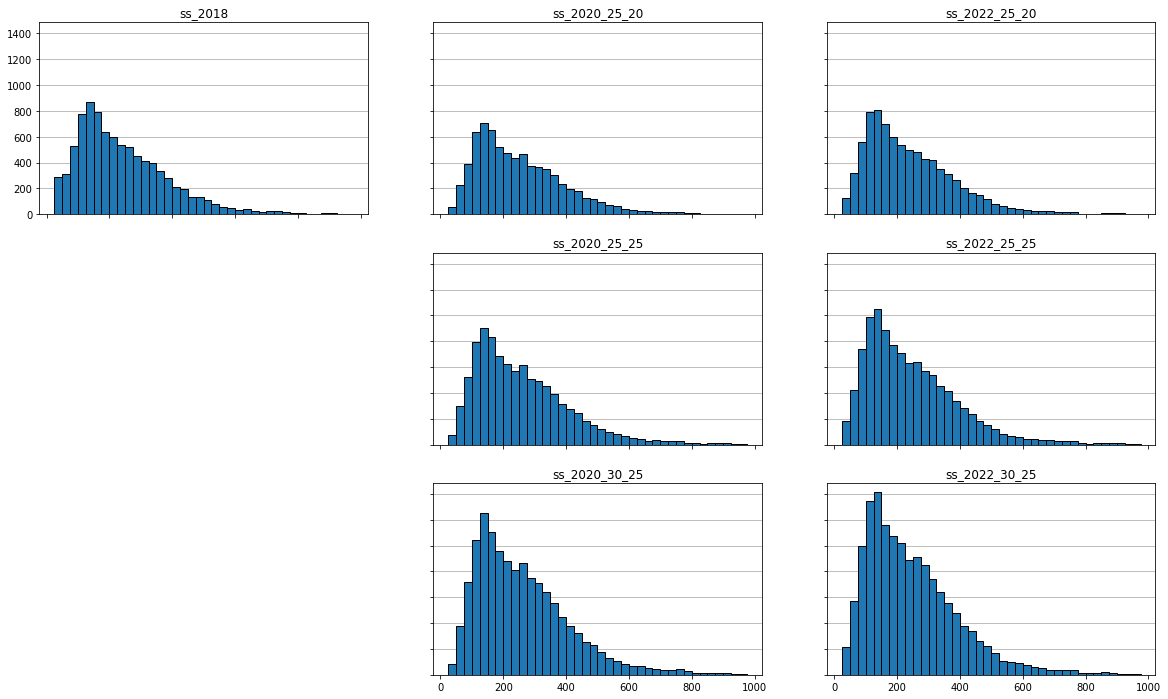

In [4]:
fig, axs = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (20, 12))

bins = range(25, 1000, 25) # bins are truncated at 1000 as there are very few sequences beyond this length

axs[0, 0].hist(ss_2018['len'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[0, 0].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 0].title.set_text('ss_2018')

axs[1, 0].axis('off')
axs[2, 0].axis('off')

axs[0, 1].hist(ss_2020_25_20['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[0, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 1].title.set_text('ss_2020_25_20')

axs[1, 1].hist(ss_2020_25_25['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[1, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 1].title.set_text('ss_2020_25_25')

axs[2, 1].hist(ss_2020_30_25['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[2, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 1].title.set_text('ss_2020_30_25')

axs[0, 2].hist(ss_2022_25_20['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[0, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 2].title.set_text('ss_2022_25_20')

axs[1, 2].hist(ss_2022_25_25['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[1, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 2].title.set_text('ss_2022_25_25')

axs[2, 2].hist(ss_2022_30_25['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[2, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 2].title.set_text('ss_2022_30_25')

fig.show()

### Secondary Structure Distibutions

The bar plots, below, show the numbers of each secondary structure type for SST-8 and SST-3 categories.  The bars are color coded by their SST-3 groupings in order to illustrate which SST-8 types are collected into SST-3 types.  The one letter abbreviations for SST-8 and SST-3 are:

SST-8 Type | Description | SST-3 Type | Description | Color
--- | --- | --- | --- | ---
B | $\beta$-bridge | E | Sheets | Yellow
E | $\beta$-strand | E | 
G | 3-helix | H | Helices | Red
H | $\alpha$-helix | H |
I | $\pi$-helix | H | 
C | Coil | C | Irregular or extended | Blue
S | Bend | C | 
T | Turn | C |

The largest dataset (2022-12-17-pdb-intersect-pisces_pc30_r2.5.csv) provides nearly 800,000 amino acids in sheets and over 1 million amino acids in helices or irregular strucutres (bends, turns, and coils).

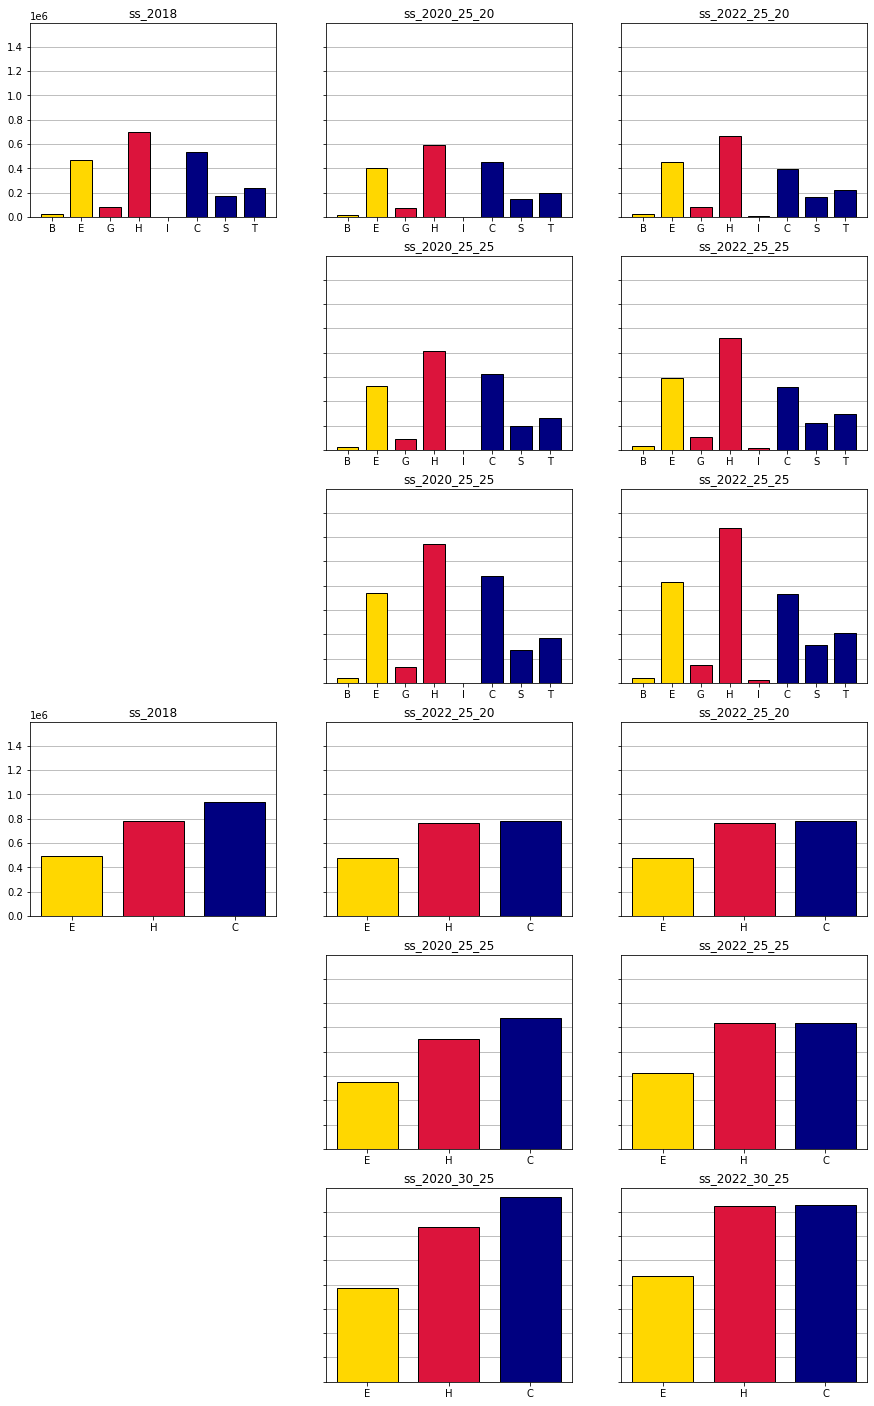

In [5]:
# set up storage for all files, both SST categoreis and the types of SST for each category
SS_counts = {'ss_2018': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2020_25_20': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2020_25_25': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2020_30_25': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2022_25_20': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2022_25_25': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2022_30_25': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) }}

# count the types for each dataset
for seq in ss_2018['sst8']:
    for ss in set(seq):
        SS_counts['ss_2018']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2018['sst3']:
    for ss in set(seq):
        SS_counts['ss_2018']['SST-3'][ss] += seq.count(ss)
        
for seq in ss_2020_25_20['sst8']:
    for ss in set(seq):
        SS_counts['ss_2020_25_20']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2020_25_20['sst3']:
    for ss in set(seq):
        SS_counts['ss_2020_25_20']['SST-3'][ss] += seq.count(ss)
        
for seq in ss_2020_25_25['sst8']:
    for ss in set(seq):
        SS_counts['ss_2020_25_25']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2020_25_25['sst3']:
    for ss in set(seq):
        SS_counts['ss_2020_25_25']['SST-3'][ss] += seq.count(ss)
        
for seq in ss_2020_30_25['sst8']:
    for ss in set(seq):
        SS_counts['ss_2020_30_25']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2020_30_25['sst3']:
    for ss in set(seq):
        SS_counts['ss_2020_30_25']['SST-3'][ss] += seq.count(ss)
        
# updated data from end of 2022
for seq in ss_2022_25_20['sst8']:
    for ss in set(seq):
        SS_counts['ss_2022_25_20']['SST-8'][ss] += seq.count(ss)

for seq in ss_2022_25_20['sst3']:
    for ss in set(seq):
        SS_counts['ss_2022_25_20']['SST-3'][ss] += seq.count(ss)
        
for seq in ss_2022_25_25['sst8']:
    for ss in set(seq):
        SS_counts['ss_2022_25_25']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2022_25_25['sst3']:
    for ss in set(seq):
        SS_counts['ss_2022_25_25']['SST-3'][ss] += seq.count(ss)
    
for seq in ss_2022_30_25['sst8']:
    for ss in set(seq):
        SS_counts['ss_2022_30_25']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2022_30_25['sst3']:
    for ss in set(seq):
        SS_counts['ss_2022_30_25']['SST-3'][ss] += seq.count(ss)
        
# plot a comparison across datasets

# define order for ss types
ss8_types = ['B', 'E', 'G', 'H', 'I', 'C', 'S', 'T']
ss3_types = ['E', 'H', 'C']

sst8_colors = ['gold', 'gold', 'crimson', 'crimson', 'crimson', 'navy', 'navy', 'navy']
sst3_colors = ['gold', 'crimson', 'navy']

fig, axs = plt.subplots(6, 3, sharey = 'all', figsize = (15, 25))

# SST-8 comparisons

axs[0, 0].bar(range(8), height = [SS_counts['ss_2018']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[0, 0].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 0].title.set_text('ss_2018')

axs[0, 1].bar(range(8), height = [SS_counts['ss_2020_25_20']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[0, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 1].title.set_text('ss_2020_25_20')

axs[0, 2].bar(range(8), height = [SS_counts['ss_2022_25_20']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[0, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 2].title.set_text('ss_2022_25_20')

axs[1, 0].axis('off')

axs[1, 1].bar(range(8), height = [SS_counts['ss_2020_25_25']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[1, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 1].title.set_text('ss_2020_25_25')

axs[1, 2].bar(range(8), height = [SS_counts['ss_2022_25_25']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[1, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 2].title.set_text('ss_2022_25_25')

axs[2, 0].axis('off')

axs[2, 1].bar(range(8), height = [SS_counts['ss_2020_30_25']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[2, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 1].title.set_text('ss_2020_25_25')

axs[2, 2].bar(range(8), height = [SS_counts['ss_2022_30_25']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[2, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 2].title.set_text('ss_2022_25_25')

# SST-3 comparisons

axs[3, 0].bar(range(3), height = [SS_counts['ss_2018']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[3, 0].grid(axis = 'y', which = 'both', zorder = 0)
axs[3, 0].title.set_text('ss_2018')

axs[3, 1].bar(range(3), height = [SS_counts['ss_2022_25_20']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[3, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[3, 1].title.set_text('ss_2022_25_20')

axs[3, 2].bar(range(3), height = [SS_counts['ss_2022_25_20']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[3, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[3, 2].title.set_text('ss_2022_25_20')

axs[4, 0].axis('off')

axs[4, 1].bar(range(3), height = [SS_counts['ss_2020_25_25']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[4, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[4, 1].title.set_text('ss_2020_25_25')

axs[4, 2].bar(range(3), height = [SS_counts['ss_2022_25_25']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[4, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[4, 2].title.set_text('ss_2022_25_25')

axs[5, 0].axis('off')

axs[5, 1].bar(range(3), height = [SS_counts['ss_2020_30_25']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[5, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[5, 1].title.set_text('ss_2020_30_25')

axs[5, 2].bar(range(3), height = [SS_counts['ss_2022_30_25']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[5, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[5, 2].title.set_text('ss_2022_30_25')

fig.show()

### Amino Acid Representation

Looking at the actual amino acid distributions in the file (ignoring those sequences with non-standard amino acids), the histograms show a similar distribution as those for the secondary structures.  The dataset with similar constraints as the 2018 original loses some content while the datasets with relaxed constraints show substantial increases in actual numbers of amino acids.  Interestingly, the table shows that across all three datasets, the relative proportions of amino acids are very well conserved.

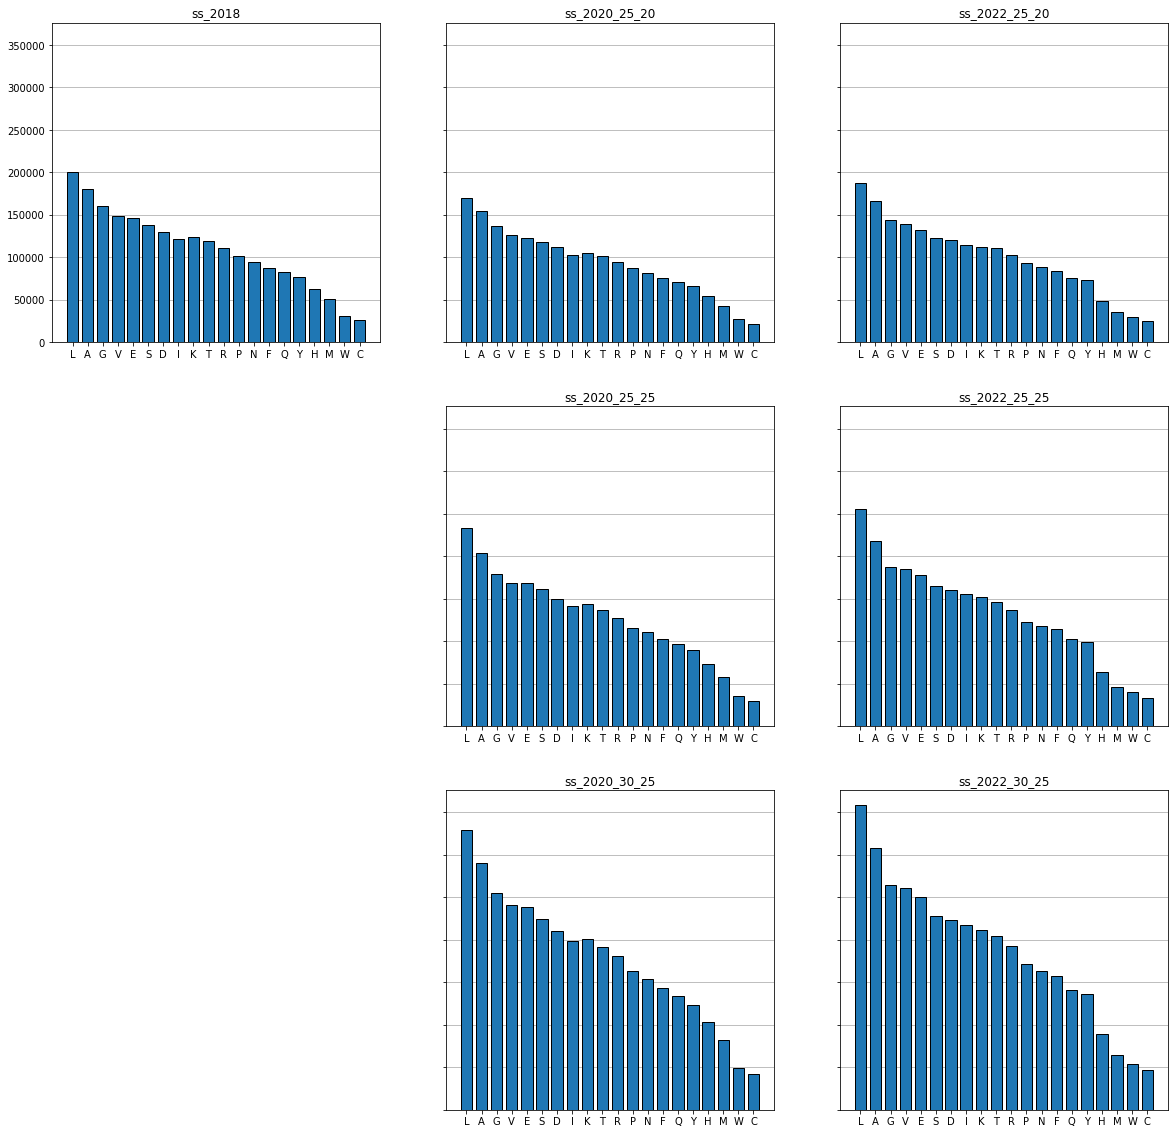

In [6]:
# set up storage for all files
AA_counts = {'ss_2018': defaultdict(lambda: 0),
             'ss_2020_25_20': defaultdict(lambda: 0),
             'ss_2020_25_25': defaultdict(lambda: 0),
             'ss_2020_30_25': defaultdict(lambda: 0),
             'ss_2022_25_20': defaultdict(lambda: 0),
             'ss_2022_25_25': defaultdict(lambda: 0),
             'ss_2022_30_25': defaultdict(lambda: 0)}

# count the types for each dataset
for (seq, nonstd) in zip(ss_2018['seq'], ss_2018['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2018'][aa] += seq.count(aa)

for (seq, nonstd) in zip(ss_2020_25_20['seq'], ss_2020_25_20['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2020_25_20'][aa] += seq.count(aa)

for (seq, nonstd) in zip(ss_2020_25_25['seq'], ss_2020_25_25['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2020_25_25'][aa] += seq.count(aa)
            
for (seq, nonstd) in zip(ss_2020_30_25['seq'], ss_2020_30_25['has_nonstd_aa']):
    if not nonstd:
        try:
            for aa in set(seq):
                if aa != '*':
                    AA_counts['ss_2020_30_25'][aa] += seq.count(aa)
        except:
            pass
                
for (seq, nonstd) in zip(ss_2022_25_20['seq'], ss_2022_25_20['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2022_25_20'][aa] += seq.count(aa)

for (seq, nonstd) in zip(ss_2022_25_25['seq'], ss_2022_25_25['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2022_25_25'][aa] += seq.count(aa)
            
for (seq, nonstd) in zip(ss_2022_30_25['seq'], ss_2022_30_25['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2022_30_25'][aa] += seq.count(aa)
            
[sum(AA_counts[d].values()) for d in AA_counts.keys()]

# order the amino acids by decreasing total abundance
total_aa = [sum([AA_counts[d][aa] for d in AA_counts.keys()]) for aa in AA_counts['ss_2018'].keys() ]
temp = sorted(total_aa, reverse = True)    
order = [total_aa.index(v) for v in temp]
aa_order = [list(AA_counts['ss_2018'].keys())[i] for i in order]

# plot a comparison across datasets
fig, axs = plt.subplots(3, 3, sharey = True, figsize = (20, 20))

axs[0, 0].bar(range(20), height = [AA_counts['ss_2018'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[0, 0].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 0].title.set_text('ss_2018')

axs[0, 1].bar(range(20), height = [AA_counts['ss_2020_25_20'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[0, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 1].title.set_text('ss_2020_25_20')

axs[0, 2].bar(range(20), height = [AA_counts['ss_2022_25_20'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[0, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 2].title.set_text('ss_2022_25_20')

axs[1, 0].axis('off')

axs[1, 1].bar(range(20), height = [AA_counts['ss_2020_25_25'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[1, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 1].title.set_text('ss_2020_25_25')

axs[1, 2].bar(range(20), height = [AA_counts['ss_2022_25_25'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[1, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 2].title.set_text('ss_2022_25_25')

axs[2, 0].axis('off')

axs[2, 1].bar(range(20), height = [AA_counts['ss_2020_30_25'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[2, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 1].title.set_text('ss_2020_30_25')

axs[2, 2].bar(range(20), height = [AA_counts['ss_2022_30_25'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[2, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 2].title.set_text('ss_2022_30_25')

fig.show()

In [7]:
# show proportion of each amino acid in a table
tbl_data = {'Amino Acid': aa_order,
            'ss_2018': [ round(AA_counts['ss_2018'][aa] / sum(AA_counts['ss_2018'].values()), 3) for aa in aa_order],
            'ss_2020_25_20': [ round(AA_counts['ss_2020_25_20'][aa] / sum(AA_counts['ss_2020_25_20'].values()), 3) for aa in aa_order],
            'ss_2020_25_25': [ round(AA_counts['ss_2020_25_25'][aa] / sum(AA_counts['ss_2020_25_25'].values()), 3) for aa in aa_order],
            'ss_2020_30_25': [ round(AA_counts['ss_2020_30_25'][aa] / sum(AA_counts['ss_2020_30_25'].values()), 3) for aa in aa_order],
            'ss_2022_25_20': [ round(AA_counts['ss_2022_25_20'][aa] / sum(AA_counts['ss_2022_25_20'].values()), 3) for aa in aa_order],
            'ss_2022_25_25': [ round(AA_counts['ss_2022_25_25'][aa] / sum(AA_counts['ss_2022_25_25'].values()), 3) for aa in aa_order],
            'ss_2022_30_25': [ round(AA_counts['ss_2022_30_25'][aa] / sum(AA_counts['ss_2022_30_25'].values()), 3) for aa in aa_order]}
pd.DataFrame(tbl_data)

,Amino Acid,ss_2018,ss_2020_25_20,ss_2020_25_25,ss_2020_30_25,ss_2022_25_20,ss_2022_25_25,ss_2022_30_25
0,L,0.091,0.091,0.092,0.093,0.093,0.095,0.095
1,A,0.082,0.083,0.081,0.082,0.083,0.081,0.082
2,G,0.073,0.073,0.071,0.072,0.072,0.069,0.070
3,V,0.068,0.068,0.067,0.068,0.069,0.069,0.069
4,E,0.067,0.066,0.067,0.067,0.066,0.066,0.066
5,S,0.063,0.063,0.064,0.063,0.061,0.061,0.061
6,D,0.059,0.060,0.059,0.059,0.060,0.059,0.059
7,I,0.055,0.055,0.056,0.056,0.057,0.058,0.058
8,K,0.056,0.056,0.057,0.057,0.056,0.056,0.056
9,T,0.054,0.055,0.054,0.054,0.055,0.054,0.054


In [8]:
# Cell 5: Custom Dataset Class with GPU Support
class ProteinDataset(Dataset):
    """Dataset class for protein secondary structure prediction."""
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        self.aa_to_idx = {aa: idx for idx, aa in enumerate('ACDEFGHIKLMNPQRSTVWY')}
        self.struct_to_idx = {'H': 0, 'E': 1, 'C': 2}
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]
        
        seq_tensor = torch.zeros(len(seq), len(self.aa_to_idx))
        for i, aa in enumerate(seq):
            if aa in self.aa_to_idx:
                seq_tensor[i, self.aa_to_idx[aa]] = 1
        
        label_tensor = torch.tensor([self.struct_to_idx[s] for s in label])
        return seq_tensor, label_tensor

In [9]:
def collate_fn(batch):
    """Custom collate function to handle variable length sequences."""
    sequences = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)
    
    return sequences_padded, labels_padded

In [10]:
def load_protein_datasets():
    """Load all protein secondary structure datasets from Kaggle paths."""
    datasets = {
        # 2018 dataset
        '2018_base': pd.read_csv('/kaggle/input/protein-secondary-structure/2018-06-06-pdb-intersect-pisces.csv'),
        
        # 2020 datasets
        '2020_25_20': pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-08-06-pdb-intersect-pisces_pc25_r2.0.csv'),
        '2020_25_25': pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-08-06-pdb-intersect-pisces_pc25_r2.5.csv'),
        '2020_30_25': pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-08-06-pdb-intersect-pisces_pc30_r2.5.csv'),
        
        # 2022 datasets
        '2022_25_20': pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-12-17-pdb-intersect-pisces_pc25_r2.0.csv'),
        '2022_25_25': pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-12-17-pdb-intersect-pisces_pc25_r2.5.csv'),
        '2022_30_25': pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-12-17-pdb-intersect-pisces_pc30_r2.5.csv')
    }
    
    return datasets

In [11]:
def prepare_data(dataset, batch_size=32, val_split=0.2, test_split=0.2):
    print("Starting data preparation...")
    
    data = dataset[~dataset['has_nonstd_aa']]
    print(f"Total sequences after filtering: {len(data)}")
    
    train_val_data, test_data = train_test_split(data, test_size=test_split, random_state=42)
    train_data, val_data = train_test_split(train_val_data, test_size=val_split, random_state=42)
    
    print(f"Train sequences: {len(train_data)}")
    print(f"Validation sequences: {len(val_data)}")
    print(f"Test sequences: {len(test_data)}")
    
    train_dataset = ProteinDataset(train_data['seq'].values, train_data['sst3'].values)
    val_dataset = ProteinDataset(val_data['seq'].values, val_data['sst3'].values)
    test_dataset = ProteinDataset(test_data['seq'].values, test_data['sst3'].values)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )
    
    return train_loader, val_loader, test_loader

def main():
    datasets = load_protein_datasets()
    
    selected_dataset = datasets['2022_25_20']
    
    train_loader, val_loader, test_loader = prepare_data(
        dataset=selected_dataset,
        batch_size=32,
        val_split=0.2,
        test_split=0.2
    )
    
    print("\nVerifying data loaders:")
    for name, loader in [("train", train_loader), ("validation", val_loader), ("test", test_loader)]:
        batch = next(iter(loader))
        sequences, labels = batch
        print(f"{name} loader - Sequence batch shape: {sequences.shape}, Labels batch shape: {labels.shape}")
    
    return train_loader, val_loader, test_loader

if __name__ == "__main__":
    train_loader, val_loader, test_loader = main()

Starting data preparation...
Total sequences after filtering: 8313
Train sequences: 5320
Validation sequences: 1330
Test sequences: 1663

Verifying data loaders:
train loader - Sequence batch shape: torch.Size([32, 867, 20]), Labels batch shape: torch.Size([32, 867])
validation loader - Sequence batch shape: torch.Size([32, 461, 20]), Labels batch shape: torch.Size([32, 461])
test loader - Sequence batch shape: torch.Size([32, 1098, 20]), Labels batch shape: torch.Size([32, 1098])


In [12]:
class CNNBiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.1):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2) 
        
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out)
        
        return output

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_size=20, hidden_size=256, num_classes=3, num_heads=8):
        super().__init__()
        
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size*4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)
        return x

In [14]:
class ModelTrainer:
    def __init__(self, model_class, train_loader, val_loader, device, 
                 num_epochs=30, learning_rate=0.001):
        self.model = model_class().to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_epochs = num_epochs
        self.criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }

    def train(self):
        print(f"Training on {self.device}")
        for epoch in range(1, self.num_epochs + 1):
            # Training phase
            self.model.train()
            train_loss = 0
            for sequences, labels in self.train_loader:
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(sequences)
                
                # Reshape for loss calculation
                outputs = outputs.view(-1, outputs.shape[-1])
                labels = labels.view(-1)
                
                # Calculate loss only for non-padded elements
                mask = (labels != -1)
                outputs = outputs[mask]
                labels = labels[mask]
                
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(self.train_loader)
            
            # Validation phase
            val_loss, val_acc = self.evaluate()
            
            # Store metrics
            self.history['train_loss'].append(avg_train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch}/{self.num_epochs}:")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_acc:.4f}")
        
        return self.model, self.history

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for sequences, labels in self.val_loader:
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(sequences)
                
                # Reshape for loss calculation
                outputs_flat = outputs.view(-1, outputs.shape[-1])
                labels_flat = labels.view(-1)
                
                # Calculate metrics only for non-padded elements
                mask = (labels_flat != -1)
                outputs_flat = outputs_flat[mask]
                labels_flat = labels_flat[mask]
                
                loss = self.criterion(outputs_flat, labels_flat)
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs_flat, 1)
                total += labels_flat.size(0)
                correct += (predicted == labels_flat).sum().item()
        
        return total_loss / len(self.val_loader), correct / total

In [15]:
# Cell 10: Training Pipeline
def train_model(model_class, train_loader, val_loader, device, num_epochs=30, patience=5):
    model = model_class(
        input_dim=20,
        hidden_dim=64,
        num_classes=3,
        num_layers=2,
        dropout=0.2
    ).to(device)
    
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = optim.Adam(model.parameters())
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for sequences, labels in train_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            
            batch_size, seq_len, num_classes = outputs.shape
            outputs = outputs.view(-1, num_classes)
            labels = labels.view(-1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                outputs = model(sequences)
                
                outputs = outputs.view(-1, num_classes)
                labels = labels.view(-1)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                mask = (labels != -1)
                _, predicted = outputs.max(1)
                total += mask.sum().item()
                correct += ((predicted == labels) & mask).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total if total > 0 else 0
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')
    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return model, history
        

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("\nTraining CNN+BiLSTM model...")
cnn_lstm_model, cnn_lstm_history = train_model(CNNBiLSTMModel, train_loader, val_loader, device)

torch.cuda.empty_cache()
gc.collect()

Using device: cuda

Training CNN+BiLSTM model...
Epoch 1/30:
Train Loss: 0.8496
Val Loss: 0.7625
Val Accuracy: 0.6640
Epoch 2/30:
Train Loss: 0.7595
Val Loss: 0.7349
Val Accuracy: 0.6779
Epoch 3/30:
Train Loss: 0.7421
Val Loss: 0.7277
Val Accuracy: 0.6818
Epoch 4/30:
Train Loss: 0.7272
Val Loss: 0.7184
Val Accuracy: 0.6869
Epoch 5/30:
Train Loss: 0.7202
Val Loss: 0.7356
Val Accuracy: 0.6792
Epoch 6/30:
Train Loss: 0.7114
Val Loss: 0.7035
Val Accuracy: 0.6934
Epoch 7/30:
Train Loss: 0.7007
Val Loss: 0.7053
Val Accuracy: 0.6929
Epoch 8/30:
Train Loss: 0.6927
Val Loss: 0.6904
Val Accuracy: 0.6999
Epoch 9/30:
Train Loss: 0.6873
Val Loss: 0.7643
Val Accuracy: 0.6750
Epoch 10/30:
Train Loss: 0.6867
Val Loss: 0.6855
Val Accuracy: 0.7021
Epoch 11/30:
Train Loss: 0.6782
Val Loss: 0.6840
Val Accuracy: 0.7034
Epoch 12/30:
Train Loss: 0.6735
Val Loss: 0.6815
Val Accuracy: 0.7049
Epoch 13/30:
Train Loss: 0.6664
Val Loss: 0.6830
Val Accuracy: 0.7032
Epoch 14/30:
Train Loss: 0.6643
Val Loss: 0.6801
V

52905

In [73]:
class ModelAnalyzer:
    def __init__(self, model, device, save_dir='/kaggle/working/'):
        self.model = model
        self.device = device
        self.struct_labels = ['H', 'E', 'C']
        self.save_dir = save_dir
    
    def get_prediction_confidence(self, test_loader):
        self.model.eval()
        confidences = []
        
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences = sequences.to(self.device)
                outputs = self.model(sequences)
                probs = torch.softmax(outputs, dim=-1)
                confidence, _ = torch.max(probs, dim=-1)
                mask = (labels != -1)
                confidences.extend(confidence[mask].cpu().numpy())
        
        return confidences
    
    def run_inference(self, test_loader):
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(sequences)
                _, predicted = torch.max(outputs.reshape(-1, outputs.shape[-1]), 1)
                
                mask = (labels.reshape(-1) != -1)
                all_preds.extend(predicted[mask].cpu().numpy())
                all_labels.extend(labels.reshape(-1)[mask].cpu().numpy())
        
        return all_preds, all_labels
    
    def show_example_predictions(self, test_loader, num_examples=3):
        self.model.eval()
        examples = []
        
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences = sequences.to(self.device)
                outputs = self.model(sequences)
                _, predicted = torch.max(outputs, 2)
                
                for i in range(min(num_examples, len(sequences))):
                    seq_len = (labels[i] != -1).sum()
                    true_struct = labels[i, :seq_len].cpu().numpy()
                    pred_struct = predicted[i, :seq_len].cpu().numpy()
                    examples.append((true_struct, pred_struct))
                
                break
        
        return examples
    
    def plot_training_metrics(self, history):
        """Plot training and validation metrics with improved clarity"""
        plt.style.use('seaborn')
        plt.figure(figsize=(15, 5))
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Plot 1: Training and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], '#2E86C1', label='Training Loss', linewidth=2)
        plt.plot(epochs, history['val_loss'], '#E74C3C', label='Validation Loss', linewidth=2)
        plt.title('Model Loss During Training', fontsize=14, pad=15)
        plt.xlabel('Training Epochs', fontsize=12)
        plt.ylabel('Cross Entropy Loss', fontsize=12)
        plt.legend(fontsize=10, frameon=True, facecolor='white', framealpha=1)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add metrics box with improved formatting
        loss_text = (f'Final Training Loss: {history["train_loss"][-1]:.4f}\n'
                    f'Final Validation Loss: {history["val_loss"][-1]:.4f}\n'
                    f'Best Training Loss: {min(history["train_loss"]):.4f}\n'
                    f'Best Validation Loss: {min(history["val_loss"]):.4f}')
        
        plt.text(0.05, 0.95, loss_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.5',
                         facecolor='white',
                         edgecolor='gray',
                         alpha=0.8))
        
        # Plot 2: Validation Accuracy
        plt.subplot(1, 2, 2)
        val_accuracies = [
            0.6640, 0.6779, 0.6818, 0.6869, 0.6792, 0.6934, 0.6929, 0.6999, 
            0.6750, 0.7021, 0.7034, 0.7049, 0.7032, 0.7060, 0.7033, 0.7060,
            0.7086, 0.7085, 0.7084, 0.7094, 0.7095, 0.7095, 0.7076, 0.7092,
            0.7094, 0.7099, 0.7104
        ]
        
        plt.plot(epochs[:len(val_accuracies)], val_accuracies, '#27AE60', 
                label='Validation Accuracy', linewidth=2)
        plt.title('Model Accuracy During Training', fontsize=14, pad=15)
        plt.xlabel('Training Epochs', fontsize=12)
        plt.ylabel('Accuracy Score', fontsize=12)
        plt.legend(fontsize=10, frameon=True, facecolor='white', framealpha=1)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Format y-axis as percentage
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        
        # Add accuracy metrics box
        acc_text = (f'Final Accuracy: {val_accuracies[-1]:.2%}\n'
                   f'Peak Accuracy: {max(val_accuracies):.2%}\n'
                   f'Early Stopping: Epoch {len(val_accuracies)}')
        
        plt.text(0.05, 0.95, acc_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.5',
                         facecolor='white',
                         edgecolor='gray',
                         alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    def save_analysis(self, predictions, true_labels, confidences, history=None):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Save model
        model_path = os.path.join(self.save_dir, f'protein_structure_model_{timestamp}.pth')
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'predictions': predictions,
            'true_labels': true_labels,
            'confidences': confidences,
            'history': history,
            'timestamp': timestamp
        }
        torch.save(checkpoint, model_path)
        
        # Save analysis results
        results_path = os.path.join(self.save_dir, f'analysis_results_{timestamp}.txt')
        with open(results_path, 'w') as f:
            f.write("Protein Structure Prediction Analysis\n")
            f.write("====================================\n\n")
            
            # Overall metrics
            accuracy = np.mean(np.array(predictions) == np.array(true_labels))
            f.write(f"Overall Accuracy: {accuracy:.4f}\n\n")
            
            # Per-class metrics
            f.write("Per-Class Performance:\n")
            for i, label in enumerate(self.struct_labels):
                class_mask = np.array(true_labels) == i
                class_accuracy = np.mean(np.array(predictions)[class_mask] == i)
                f.write(f"{label} Structure Accuracy: {class_accuracy:.4f}\n")
            
            # Confidence statistics
            f.write("\nConfidence Statistics:\n")
            f.write(f"Overall Mean: {np.mean(confidences):.4f}\n")
            f.write(f"Overall Std: {np.std(confidences):.4f}\n")
            
            # Per-class confidence
            f.write("\nPer-Class Confidence:\n")
            for i, label in enumerate(self.struct_labels):
                class_mask = np.array(predictions) == i
                class_confidences = np.array(confidences)[class_mask]
                f.write(f"\n{label} Structure:\n")
                f.write(f"  Mean: {np.mean(class_confidences):.4f}\n")
                f.write(f"  Std: {np.std(class_confidences):.4f}\n")
                f.write(f"  Min: {np.min(class_confidences):.4f}\n")
                f.write(f"  Max: {np.max(class_confidences):.4f}\n")
            
            # Classification report
            f.write("\nDetailed Classification Report:\n")
            f.write(classification_report(true_labels, predictions,
                                       target_names=self.struct_labels,
                                       digits=4))
        
        print(f"\nModel saved to: {model_path}")
        print(f"Analysis results saved to: {results_path}")
        return model_path, results_path



Analyzing training results...

Model saved to: /kaggle/working/protein_structure_model_20250220_004655.pth
Analysis results saved to: /kaggle/working/analysis_results_20250220_004655.txt

Training Metrics (Epoch 27/30):
Train Loss: 0.6229
Val Loss: 0.6740
Val Accuracy: 0.7104


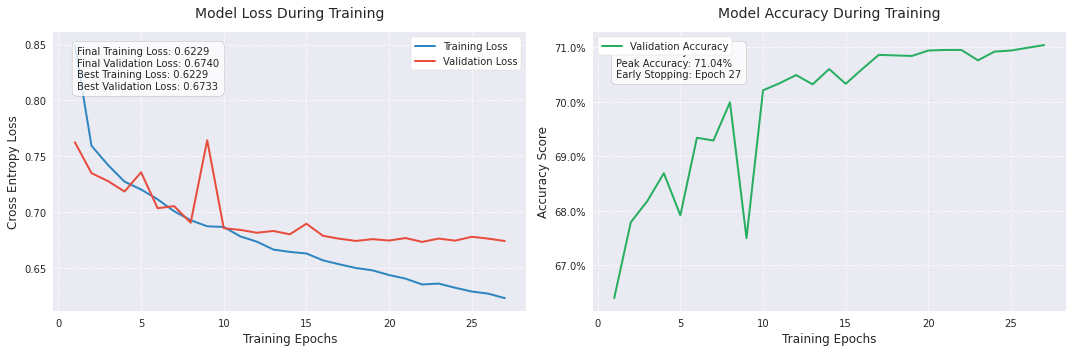


Best Metrics:
Best Training Loss: 0.6229 (Epoch 27)
Best Validation Loss: 0.6733 (Epoch 22)


6437

In [74]:
# Initialize analyzer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
analyzer = ModelAnalyzer(model=cnn_lstm_model, device=device)

# Run analysis
print("\nAnalyzing training results...")
predictions, true_labels = analyzer.run_inference(test_loader)
confidences = analyzer.get_prediction_confidence(test_loader)

# Save analysis results
model_path, results_path = analyzer.save_analysis(
    predictions=predictions,
    true_labels=true_labels,
    confidences=confidences,
    history=cnn_lstm_history
)

# Print training metrics from epoch 27
print("\nTraining Metrics (Epoch 27/30):")
print(f"Train Loss: 0.6229")
print(f"Val Loss: 0.6740")
print(f"Val Accuracy: 0.7104")

# Plot the results
analyzer.plot_training_metrics(cnn_lstm_history)

# Print best metrics from history
print("\nBest Metrics:")
best_train_loss = min(cnn_lstm_history['train_loss'])
best_val_loss = min(cnn_lstm_history['val_loss'])

print(f"Best Training Loss: {best_train_loss:.4f} (Epoch {cnn_lstm_history['train_loss'].index(best_train_loss)+1})")
print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {cnn_lstm_history['val_loss'].index(best_val_loss)+1})")

# Clean up
torch.cuda.empty_cache()
gc.collect()

Initializing analysis...

Analyzing prediction confidence...


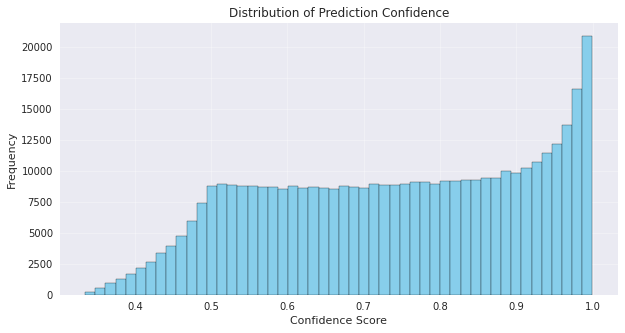

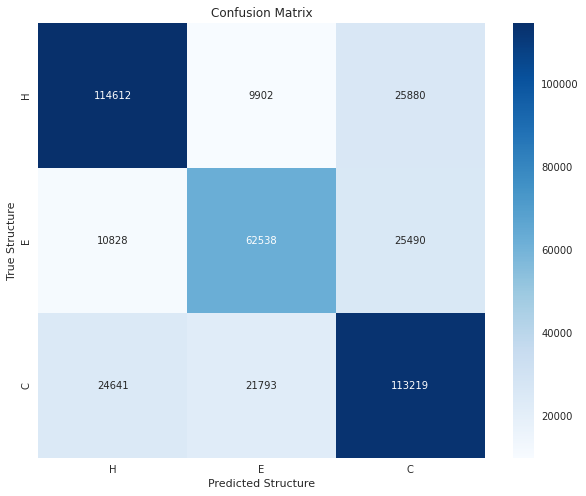

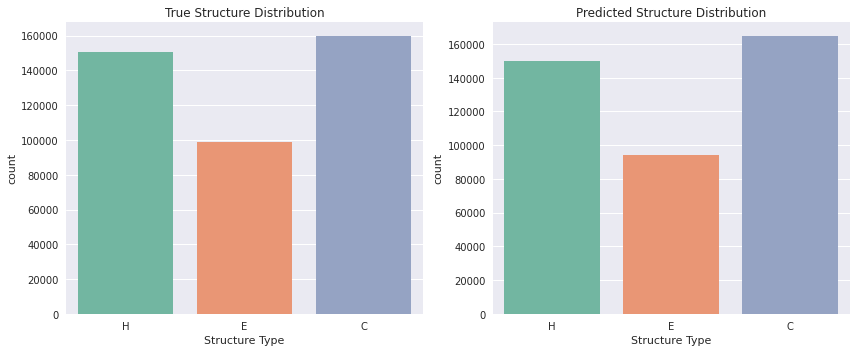

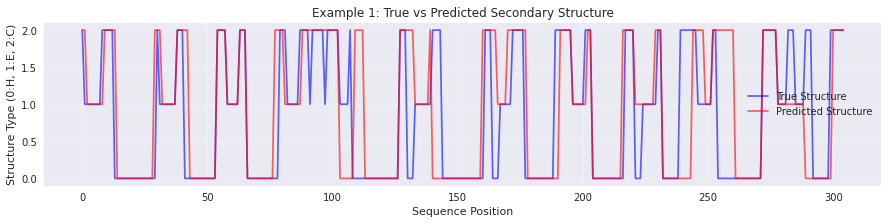

Example 1 - Prediction agreement: 78.03%


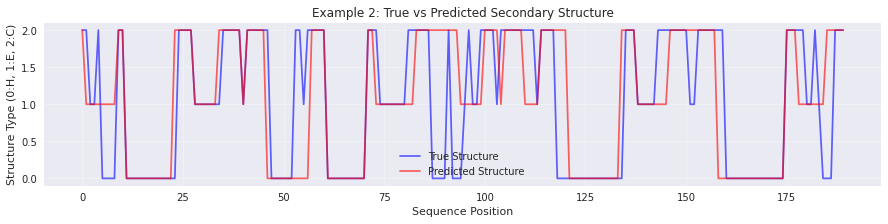

Example 2 - Prediction agreement: 75.26%


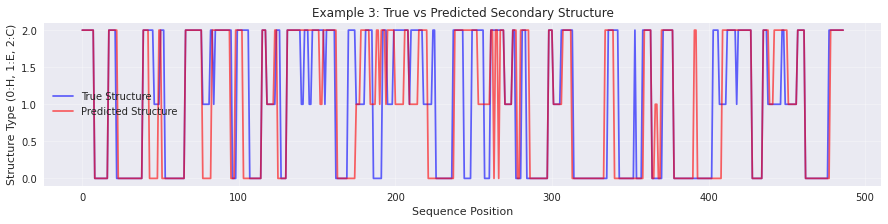

Example 3 - Prediction agreement: 73.92%

Summary Statistics:
Overall Accuracy: 0.7101
H Structure Accuracy: 0.7621
E Structure Accuracy: 0.6326
C Structure Accuracy: 0.7092

H Structure Confidence:
  Mean: 0.8013
  Std: 0.1763
  Min: 0.3354
  Max: 0.9998

E Structure Confidence:
  Mean: 0.7272
  Std: 0.1723
  Min: 0.3355
  Max: 0.9987

C Structure Confidence:
  Mean: 0.6969
  Std: 0.1511
  Min: 0.3349
  Max: 0.9970


In [38]:
# Run the analysis
print("Initializing analysis...")
analyzer = ModelAnalyzer(cnn_lstm_model, device)

# Get predictions and confidences
print("\nAnalyzing prediction confidence...")
confidences = analyzer.get_prediction_confidence(test_loader)
predictions, true_labels = analyzer.run_inference(test_loader)

# Plot confidence distribution
plt.figure(figsize=(10, 5))
plt.hist(confidences, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=analyzer.struct_labels,
           yticklabels=analyzer.struct_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Structure')
plt.ylabel('True Structure')
plt.show()

# Plot structure distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=pd.DataFrame({'Structure': true_labels}), x='Structure', palette='Set2')
plt.title('True Structure Distribution')
plt.xlabel('Structure Type')
plt.xticks([0, 1, 2], ['H', 'E', 'C'])

plt.subplot(1, 2, 2)
sns.countplot(data=pd.DataFrame({'Structure': predictions}), x='Structure', palette='Set2')
plt.title('Predicted Structure Distribution')
plt.xlabel('Structure Type')
plt.xticks([0, 1, 2], ['H', 'E', 'C'])
plt.tight_layout()
plt.show()

# Show example predictions
examples = analyzer.show_example_predictions(test_loader, num_examples=3)
for i, (true_struct, pred_struct) in enumerate(examples):
    plt.figure(figsize=(15, 3))
    plt.plot(true_struct, label='True Structure', color='blue', alpha=0.6)
    plt.plot(pred_struct, label='Predicted Structure', color='red', alpha=0.6)
    plt.title(f'Example {i+1}: True vs Predicted Secondary Structure')
    plt.ylabel('Structure Type (0:H, 1:E, 2:C)')
    plt.xlabel('Sequence Position')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    agreement = np.mean(true_struct == pred_struct) * 100
    print(f"Example {i+1} - Prediction agreement: {agreement:.2f}%")

# Print summary statistics
print("\nSummary Statistics:")
accuracy = np.mean(np.array(predictions) == np.array(true_labels))
print(f"Overall Accuracy: {accuracy:.4f}")

for i, label in enumerate(analyzer.struct_labels):
    class_mask = np.array(true_labels) == i
    class_accuracy = np.mean(np.array(predictions)[class_mask] == i)
    print(f"{label} Structure Accuracy: {class_accuracy:.4f}")

for i, label in enumerate(analyzer.struct_labels):
    class_mask = np.array(predictions) == i
    class_confidences = np.array(confidences)[class_mask]
    print(f"\n{label} Structure Confidence:")
    print(f"  Mean: {np.mean(class_confidences):.4f}")
    print(f"  Std: {np.std(class_confidences):.4f}")
    print(f"  Min: {np.min(class_confidences):.4f}")
    print(f"  Max: {np.max(class_confidences):.4f}")

# Save all results
model_path, results_path = analyzer.save_analysis(predictions, true_labels, confidences, cnn_lstm_history)